In [27]:
import scipy.misc
from scipy.misc import comb as ncomb
import numpy as np
from itertools import combinations
import pandas as pd
import sys
sys.path.append('../../mainstream/src/scheduler')
sys.path.append('../../mainstream/data')
sys.path.append('../scripts/util')
import plot_util
import app_data_mobilenets as app_data
import scheduler_util
%pprint on
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

Pretty printing has been turned ON


In [28]:
num_framerates = 15
num_frozen = 10
# num_framerates = 5
# num_frozen = 10

In [29]:
data = []
x, y, z = [], [], []
for framerates_ in range(1,20+1):
    row = []
    for frozen_ in range(1,20+1):
        dd = [ncomb(framerates_, i, exact=True) * ncomb(frozen_, i, exact=True) for i in range(1,frozen_+1)]
        row.append(sum(dd))
        x.append(framerates_)
        y.append(frozen_)
        z.append(sum(dd))
    data.append(row)
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,2,5,9,14,20,27,35,44,54,65,77,90,104,119,135,152,170,189,209,230
2,3,9,19,34,55,83,119,164,219,285,363,454,559,679,815,968,1139,1329,1539,1770
3,4,14,34,69,125,209,329,494,714,1000,1364,1819,2379,3059,3875,4844,5984,7314,8854,10625
4,5,20,55,125,251,461,791,1286,2001,3002,4367,6187,8567,11627,15503,20348,26333,33648,42503,53129
5,6,27,83,209,461,923,1715,3002,5004,8007,12375,18563,27131,38759,54263,74612,100946,134595,177099,230229
6,7,35,119,329,791,1715,3431,6434,11439,19447,31823,50387,77519,116279,170543,245156,346103,480699,657799,888029
7,8,44,164,494,1286,3002,6434,12869,24309,43757,75581,125969,203489,319769,490313,735470,1081574,1562274,2220074,3108104
8,9,54,219,714,2001,5004,11439,24309,48619,92377,167959,293929,497419,817189,1307503,2042974,3124549,4686824,6906899,10015004
9,10,65,285,1000,3002,8007,19447,43757,92377,184755,352715,646645,1144065,1961255,3268759,5311734,8436284,13123109,20030009,30045014


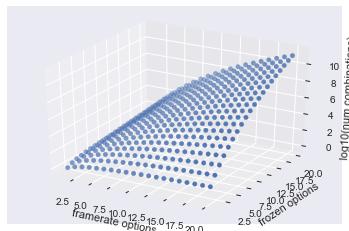

In [30]:
# %matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, np.log10(z))
ax.set_xlabel('framerate options')
ax.set_ylabel('frozen options')
ax.set_zlabel('log10(num combinations)')

In [31]:
stems = []
latencies = np.cumsum(app_data.mobilenets_layer_latencies)
chokepoints = sorted(app_data.accuracy_pedestrian_mobilenets.keys())
for i in range(1, num_frozen+1):
    for c_framerates in combinations(range(1, num_framerates+1), i):
        for c_frozen_ in combinations(range(num_frozen), i):
            c_frozen = [chokepoints[fr] for fr in c_frozen_]
            stem = zip(c_framerates, c_frozen)
            cost = scheduler_util.get_stem_cost(stem, latencies, app_data.model_desc["total_layers"])
            stems.append((stem, cost))

In [32]:
costs = [cost for _, cost in stems]

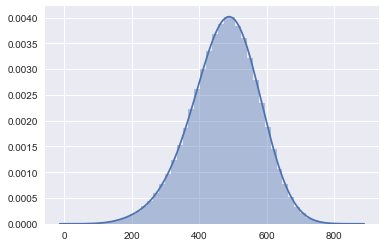

In [33]:
import seaborn as sns
sns.distplot(costs)

In [34]:
dd = sorted(Counter(costs).items())

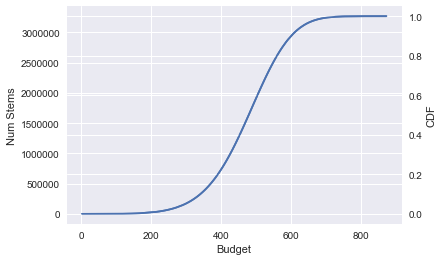

In [35]:
fig, ax1 = plt.subplots()
x, y = zip(*dd)
y = np.cumsum(y)
ax1.set_xlabel('Budget')
ax1.set_ylabel('Num Stems')
ax1.plot(x, y)

ax2 = ax1.twinx()
y = y / float(y[-1])
ax2.set_xlabel('Budget')
ax2.set_ylabel('CDF')
ax2.plot(x, y)

(0, 30000)

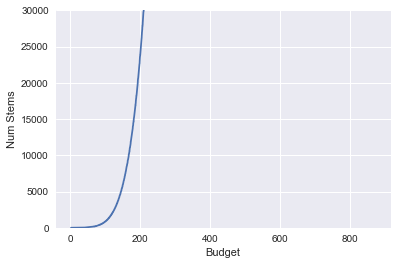

In [39]:
x, y = zip(*dd)
y = np.cumsum(y)
plt.plot(x, y)
plt.xlabel('Budget')
plt.ylabel('Num Stems')
plt.ylim(0, 30000)

In [37]:
ddd = defaultdict(Counter)
for stem, cost in stems:
    ddd[len(stem)][cost] += 1

NameError: name 'defaultdict' is not defined

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Budget')
ax1.set_ylabel('Num Stems CDF')

for stem_len, dddd in ddd.items():
    x, y = zip(*sorted(dddd.items()))
    y = np.cumsum(y)
    y = y / float(y[-1])
    ax1.plot(x, y, label=stem_len, c=plot_util.COLORLISTS[12][stem_len-1])
plt.legend()

In [ ]:
[stem for stem, _ in stems[20000:20010]]
